In [1]:
from PIL import Image, ImageDraw
from random import choice

#@title Генератор рандомных shape
#@markdown Что важно: каждая из трех форм может быть только двух цветов
def create_shape_image(size=64,
                       shapes=['circle','square','triangle'],
                       colors=['yellow','magenta','pink'],
                       back_color='white'):
    # Создаем пустое изображение
    width = height = size
    shape = choice(shapes)
    shape_index = shapes.index(shape)
    # Создаем новый массив colors, исключая элемент с индексом shape_index
    remaining_colors = [color for i, color in enumerate(colors) if i != shape_index]
    color = choice(remaining_colors)
    color_index = colors.index(color)
    image = Image.new("RGB", (width, height), back_color)
    draw = ImageDraw.Draw(image)

    # Определяем центр изображения
    center_x = width // 2
    center_y = height // 2

    # Определяем Фигуру
    if shape == "circle":
        # Рисуем круг
        radius = min(center_x, center_y) // 2  # Определяем радиус круга
        draw.ellipse((center_x - radius, center_y - radius, center_x + radius, center_y + radius), fill=color)
    elif shape == "square":
        # Рисуем квадрат
        side_length = min(center_x, center_y) // 6 * 5  # Определяем длину стороны квадрата
        left = center_x - side_length // 2
        top = center_y - side_length // 2
        right = center_x + side_length // 2
        bottom = center_y + side_length // 2
        draw.rectangle([left, top, right, bottom], fill=color)
    elif shape == "triangle":
        # Рисуем равносторонний треугольник
        side_length = min(center_x, center_y)  # Определяем длину стороны треугольника
        height = (3 ** 0.5 / 2) * side_length
        x1 = center_x - side_length // 2
        y1 = center_y + height // 2
        x2 = center_x + side_length // 2
        y2 = center_y + height // 2
        x3 = center_x
        y3 = center_y - height // 2
        draw.polygon([(x1, y1), (x2, y2), (x3, y3)], fill=color)

    return shape_index, color_index, image


In [2]:
import torch
from torchvision import transforms
from torch.utils.data import IterableDataset, DataLoader

#@title Датасет
#@markdown Применяем рандомные трансформации:смещение и поворот
class shapeDataset(IterableDataset):
    def gen(self):
      for i in range(self.num_samples):
        shape_index, color_index, image = create_shape_image(self.image_size+15)
        yield {"shape_index":shape_index,
               "color_index":color_index,
               "rand_seed":torch.rand(3),
               "image": self.transform(image)}

    def __init__(self, image_size=64,n=1000):
        self.num_samples = n
        self.image_size = image_size
        self.transform = transforms.Compose([
            transforms.RandomRotation(degrees=(0, 180),fill=255),
            transforms.RandomCrop((image_size,image_size)),
            transforms.ToTensor(),  # Преобразование в тензор
        ])
        self.generator = self.gen

    def __len__(self):
      return self.num_samples

    def __iter__(self):
        return self.generator()


train_data = shapeDataset(n=51200)
test_data = shapeDataset(n=5120)


In [3]:
# Создаем DataLoader для итерации по данным
batch_size = 512
data_tr = DataLoader(train_data, batch_size=batch_size)
data_val = DataLoader(test_data, batch_size=batch_size)

In [4]:
from torch import nn
from torch.autograd import Variable

#@title Наша модель CVAE (Сonditional VAE - условный, вариационный, сверточный автоэнкодер)
#@markdown почти как обычный VAE, но в декодер подаем еще
#@markdown обучаемые представления shape и color
class CVAE(nn.Module):
    def __init__(self, ch=3, zDim=16):
        super(CVAE, self).__init__()
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(ch, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32, momentum=0.5),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32, momentum=0.5),
            nn.ReLU(),
        )
        self.pool1 = nn.MaxPool2d(3, stride=2, padding=1) # 64 -> 32
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum=0.5),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum=0.5),
            nn.ReLU(),
        )
        self.pool2 = nn.MaxPool2d(3, stride=2, padding=1) # 32 -> 16
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, momentum=0.5),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, momentum=0.5),
            nn.ReLU(),
        )
        self.pool3 = nn.MaxPool2d(3, stride=2, padding=1) # 16 -> 8

        # bottleneck
        self.mu_FC = nn.Linear(128*8*8, zDim)
        self.sigma_FC = nn.Linear(128*8*8, zDim)

        self.shape_emd = nn.Embedding(3,zDim)
        self.color_emd = nn.Embedding(3,zDim)
        self.dec_FC = nn.Linear(zDim, 128*8*8)

        self.dec_conv1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2), # 8 -> 16
            nn.BatchNorm2d(64, momentum=0.5),
            nn.ReLU(),
        )
        self.dec_conv2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 2, stride=2), # 16 -> 32
            nn.BatchNorm2d(32, momentum=0.5),
            nn.ReLU(),
        )
        self.dec_conv3 = nn.Sequential(
            nn.ConvTranspose2d(32, ch, 2, stride=2), # 32 -> 64
            #nn.BatchNorm2d(32, momentum=0.5),
            nn.Sigmoid(),
        )

    def encode(self, x):
        # encoder
        x = self.pool1(self.enc_conv1(x))
        x = self.pool2(self.enc_conv2(x))
        x = self.pool3(self.enc_conv3(x))

        # bottleneck
        x = x.reshape(-1, 128*8*8)
        mu = self.mu_FC(x)
        logsigma = self.sigma_FC(x)

        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma) # standard deviation
            eps = torch.randn_like(std) # `randn_like` as we need the same size
            sample = mu + (eps * std) # sampling as if coming from the input space
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z, c, s):
        z += self.shape_emd(s)
        z += self.color_emd(c)
        x = self.dec_FC(z)
        x = x.reshape(-1, 128,8,8)

        # decoder
        x = self.dec_conv1(x)
        x = self.dec_conv2(x)
        x = self.dec_conv3(x)
        return x

    def forward(self, x, c, s):
        mu, logsigma = self.encode(x)
        samle = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(samle, c, s)
        return mu, logsigma, reconstruction

In [5]:
#@title Loss функция: правдоподобие + дивергения
def KL_divergence(mu, logsigma):
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    loss = nn.BCELoss(reduction='sum') #<binary cross-entropy>
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return  KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

In [6]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [7]:
criterion = loss_vae
autoencoder = CVAE().to(device)
#autoencoder.load_state_dict(torch.load('last.ckpt'))
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

In [8]:
import numpy as np
from matplotlib.widgets import Circle
import matplotlib.pyplot as plt
from IPython.display import clear_output
from random import random

shapes=['circle','square','triangle']
colors=['yellow','magenta','pink']

#@title Процедура тренировки с выводом промежуточных результатов
def train(model, opt, loss_fn, epochs, data_tr, data_val, usecls=True):
    for epoch in range(epochs):
        val = next(iter(data_val))
        v_si = val['shape_index']
        v_ci = val['color_index']
        v_batch = val['image']

        #tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for batch in data_tr:
            si = batch['shape_index']
            ci = batch['color_index']
            batch = batch['image']
            # data to device
            batch = batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            #print(batch.shape)
            if usecls:
              mu, sigma, pred = model(batch,si.to(device),ci.to(device))
            else:
              mu, sigma, pred = model(batch)
            #print(Y_pred.shape,Y_batch.shape)
            loss = loss_fn(batch, mu, sigma, pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step() # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        #toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        with torch.no_grad():
          if usecls:
            _, _, Y_hat = model(v_batch.to(device),v_si.to(device),v_ci.to(device)) # detach and put into cpu
            ox = torch.where(torch.randint(0, 2, size=v_si.shape, dtype=torch.bool), v_si, v_ci)
            _, _, Y_ox = model(v_batch.to(device),ox.to(device),ox.to(device)) # detach and put into cpu
          else:
            _, _, Y_hat = model(val.to(device)) # detach and put into cpu
          Y_hat = Y_hat.cpu()
          Y_ox = Y_ox.cpu()
        # Visualize tools
        clear_output(wait=True)
        plt.figure(figsize=(18, 9))
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(v_batch[k].numpy(), 0, 3))
            plt.title(f'Real <{colors[v_ci[k].item()]} {shapes[v_si[k].item()]}>')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(np.rollaxis(Y_hat[k].numpy(), 0, 3))
            plt.title(f'Output <{colors[v_ci[k].item()]} {shapes[v_si[k].item()]}>')
            plt.axis('off')

            plt.subplot(3, 6, k+13)
            plt.imshow(np.rollaxis(Y_ox[k].numpy(), 0, 3))
            plt.title(f'NEW <{colors[ox[k].item()]} {shapes[ox[k].item()]}>')
            plt.axis('off')

        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

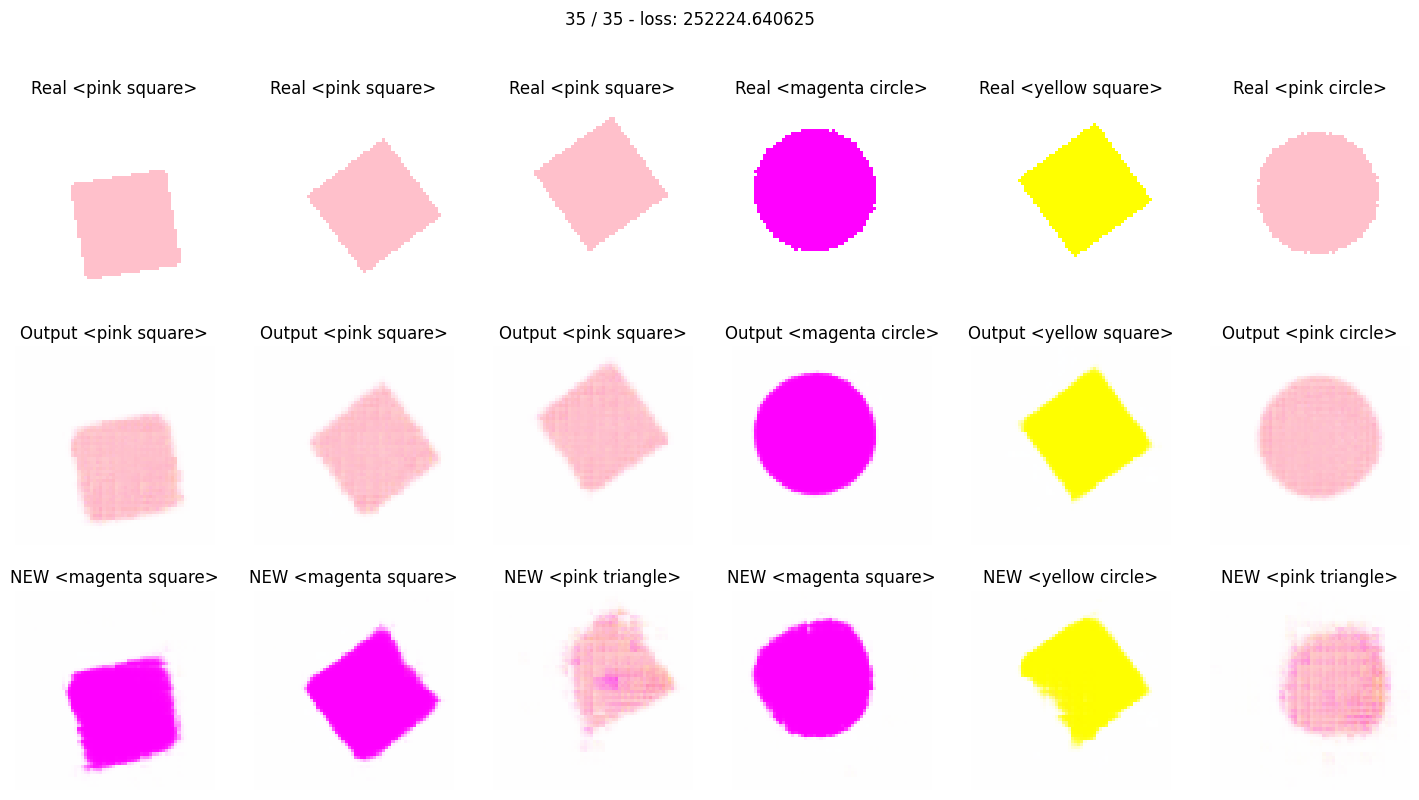

In [9]:
#@title Учим!

epochs = 35 #@param {type:"integer"}

train(autoencoder, optimizer, criterion, epochs, data_tr, data_val)

In [10]:
torch.save(autoencoder.state_dict(), "last.ckpt")

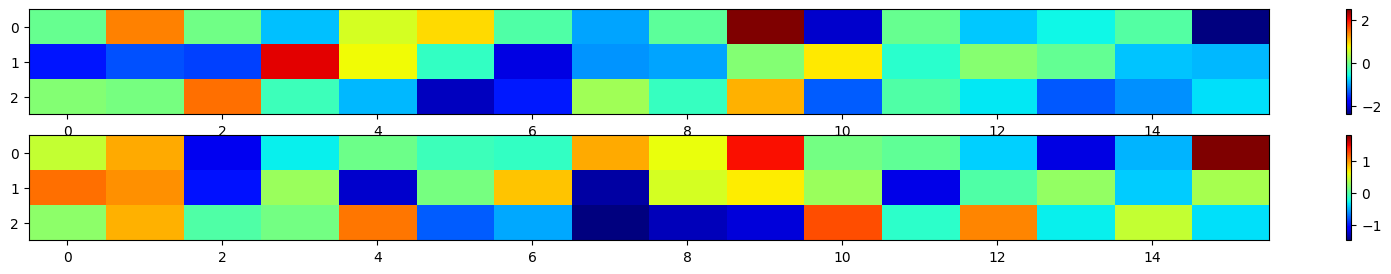

In [11]:
#@title выученные латентные представления - чисто посмотреть. 😊
plt.figure(figsize=(20, 3))
plt.subplot(2, 1, 1)
plt.imshow(autoencoder.shape_emd.weight[:,:].cpu().detach().numpy(), cmap='jet', aspect='auto')
plt.colorbar()
plt.subplot(2, 1, 2)
plt.imshow(autoencoder.color_emd.weight[:,:].cpu().detach().numpy(), cmap='jet', aspect='auto')
plt.colorbar()

In [12]:
#@title Определим пространство из которого семплировать...
data_val = DataLoader(test_data, batch_size=256)
res = []
autoencoder.eval()
for epoch in range(10):
    val = next(iter(data_val))
    v_batch = val['image']
    res.append(autoencoder.encode(v_batch.to(device))[0])
res = torch.cat(res)
std = torch.std(res,0)
mean = torch.mean(res,0)

(-0.5, 63.5, 63.5, -0.5)

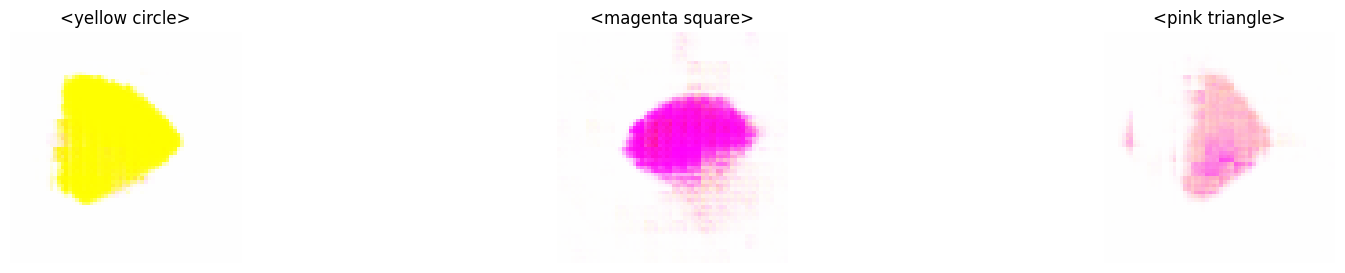

In [13]:
#@title Тест на воображение!
plt.figure(figsize=(20, 3))
plt.subplot(1, 3, 1)
Y_ox = autoencoder.decode(torch.normal(mean,std).unsqueeze(0).to(device),torch.LongTensor([0]).to(device),torch.LongTensor([0]).to(device))
plt.imshow(np.rollaxis(Y_ox[0].cpu().detach().numpy(), 0, 3))
plt.title(f'<{colors[0]} {shapes[0]}>')
plt.axis('off')
plt.subplot(1, 3, 2)
Y_ox = autoencoder.decode(torch.normal(mean,std).unsqueeze(0).to(device),torch.LongTensor([1]).to(device),torch.LongTensor([1]).to(device))
plt.imshow(np.rollaxis(Y_ox[0].cpu().detach().numpy(), 0, 3))
plt.title(f'<{colors[1]} {shapes[1]}>')
plt.axis('off')
plt.subplot(1, 3, 3)
Y_ox = autoencoder.decode(torch.normal(mean,std).unsqueeze(0).to(device),torch.LongTensor([2]).to(device),torch.LongTensor([2]).to(device))
plt.imshow(np.rollaxis(Y_ox[0].cpu().detach().numpy(), 0, 3))
plt.title(f'<{colors[2]} {shapes[2]}>')
plt.axis('off')
